### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта 

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 4


### Дисциплина: Методы машинного обучения

##### Студент:  Матюхин Григорий Васильевич
##### Группа:   НПИбд-01-21

## Москва 2024
***

### Вариант №4
1. Набор данных: `penguins`
2. Независимые признаки: `X0`, `X1`
3. Метка класса: `species`
4. Показатель бинарной классификации: _FP_ (False Positives) – число точек в отрицательном классе, ошибочно спрогнозированных в положительный класс
5. Параметры нейронных сетей:
    - Кол-во скрытых слоев: 2, 3, 4
    - Кол-во нейронов в слоях задать так, чтобы общее количество параметров в разных сетях было примерно одинаковым. 
    - Оптимизатор: `AdamW`
    - Функция активации в скрытых слоях: `selu`

# Выполнение

## 1. Загружаем датасет

In [1]:
import tensorflow_datasets as tfds

In [2]:
ds = tfds.load("penguins", split="train")
full_df = tfds.as_dataframe(ds)
full_df.head()

2024-05-10 01:13:57.886386: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 01:13:57.889347: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 01:13:57.937664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 01:13:58.855124: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-10 01:13:59.741210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,features,species
0,"[0.6545454, 0.22619048, 0.89830506, 0.6388889]",2
1,"[0.36, 0.04761905, 0.6440678, 0.4027778]",2
2,"[0.68, 0.30952382, 0.91525424, 0.6944444]",2
3,"[0.6181818, 0.20238096, 0.8135593, 0.6805556]",2
4,"[0.5527273, 0.26190478, 0.84745765, 0.7083333]",2


In [3]:
for i in range(len(full_df["features"][0])):
    full_df[f"V{str(i)}"] = full_df["features"].apply(lambda x: x[i])
full_df.drop(columns=["features"], inplace=True)
full_df.head()

,species,V0,V1,V2,V3
0,2,0.654545,0.226190,0.898305,0.638889
1,2,0.360000,0.047619,0.644068,0.402778
2,2,0.680000,0.309524,0.915254,0.694444
3,2,0.618182,0.202381,0.813559,0.680556
4,2,0.552727,0.261905,0.847458,0.708333


In [4]:
X0 = "V0"
X1 = "V1"
CLS = "species"

In [5]:
import pandas as pd

In [6]:
df = pd.DataFrame(full_df, columns=[CLS, X0, X1])
df.head()

,species,V0,V1
0,2,0.654545,0.226190
1,2,0.360000,0.047619
2,2,0.680000,0.309524
3,2,0.618182,0.202381
4,2,0.552727,0.261905


## 2. Визуализация классов

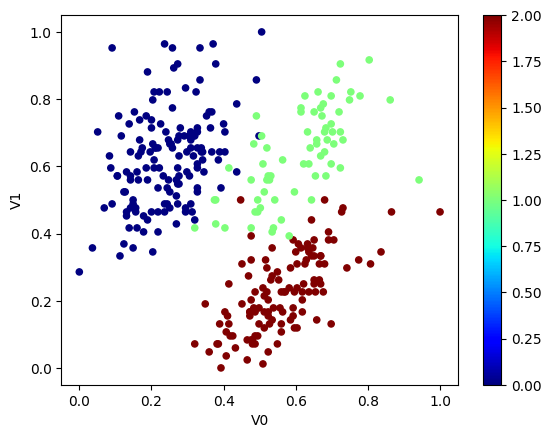

In [7]:
plt = df.plot.scatter(X0, X1, c = df[CLS], cmap="jet")

## 2. Объединение классов

In [8]:
for cls in set(df[CLS]):
    print("Entries for class", cls, "=", len(df[(df[CLS] == cls)]))

Entries for class 0 = 146
Entries for class 1 = 68
Entries for class 2 = 120


In [9]:
df[CLS] = df[CLS].map(lambda x: [0, 1, 1][x])

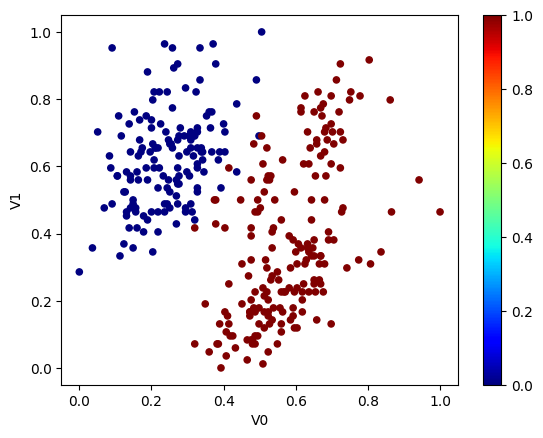

In [10]:
plt = df.plot.scatter(X0, X1, c = df[CLS], cmap="jet")

## 4. Подготовка нейросети

### 4.1 Обучающая и тестовая выборки

In [11]:
import numpy as np

In [12]:
seed = 123
split = 0.5
train = df.sample(frac=split, random_state=seed)
test = df.drop(train.index)
len(train), len(test)

(167, 167)

In [13]:
train_in = np.asarray(train.drop(columns=[CLS]))
train_out = np.asarray(train.drop(columns=[X0, X1]))

test_in = np.asarray(test.drop(columns=[CLS]))
test_out = np.asarray(test.drop(columns=[X0, X1]))

full_in = np.asarray(df.drop(columns=[CLS]))
full_out = np.asarray(df.drop(columns=[X0, X1]))

### 4.2 Нейросети

In [14]:
import tensorflow as tf

In [15]:
norm = tf.keras.layers.Normalization(axis=None)
norm.adapt(train_in)

In [16]:
def make_model(name, hidden_n, neurons_in_layer):
    layers = [tf.keras.layers.Dense(neurons_in_layer, activation="selu") for _ in range(hidden_n)]
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape= train_in[0].shape),
        norm,
        *layers,
        tf.keras.layers.Dense(1, activation="sigmoid")
    ], name=name)

    model.summary()

    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
        metrics=["false_positives"]
    )
    return model

In [17]:
configs = [
    {
        "name": "model1",
        "layers": 2,
        "neurons_in_layer": 64,
    },
    {
        "name": "model2",
        "layers": 3,
        "neurons_in_layer": 46,
    },
    {
        "name": "model3",
        "layers": 4,
        "neurons_in_layer": 37,
    },
]

models = [
    {
        "model": make_model(c["name"], c["layers"], c["neurons_in_layer"]),
        "hist": None,
        "metric": None,
    }
    for c in configs
]

Model: "model1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,420 (17.27 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 3 (16.00 B)

Model: "model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 46)             │           138 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            47 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,512 (17.63 KB)

 Trainable params: 4,509 (17.61 KB)

 Non-trainable params: 3 (16.00 B)

Model: "model3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 37)             │           111 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 37)             │         1,406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 37)             │         1,406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 37)             │         1,406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            38 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,370 (17.07 KB)

 Trainable params: 4,367 (17.06 KB)

 Non-trainable params: 3 (16.00 B)

In [18]:
for model in models:
    print(f"Fitting model '{model['model'].name}'")
    model["hist"] = model["model"].fit(train_in, train_out, epochs=500, verbose=0)

Fitting model 'model1'
Fitting model 'model2'
Fitting model 'model3'


In [19]:
for model in models:
    _, fp = model["model"].evaluate(test_in, test_out)
    print(f"FP for '{model['model'].name}': {fp}")
    model["metric"] = fp

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - false_positives: 0.8571 - loss: 0.8694      
FP for 'model1': 1.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - false_positives: 1.8571 - loss: 0.8054  
FP for 'model2': 2.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - false_positives: 0.8571 - loss: 0.9084      
FP for 'model3': 1.0


In [20]:
idx = np.argmin([x["metric"] for x in models[::-1]])
print("Best model:", models[::-1][idx]["model"].name)
best_model = models[idx]["model"].name

Best model: model3


## 5. Границы принятия решений

In [21]:
def plot_decision_boundary(model, X, y):
    # Найдем диапазоны изменения по осям и построим сетку
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    # Набор данных для прогнозирования
    X_in = np.c_[xx.ravel(), yy.ravel()]
    # Прогноз при помощи обученной модели
    y_pred = model.predict(X_in)
    # Проверка мультиклассовости
    if len(y_pred[1]) > 1:
        # мультиклассовая классификация
        # изменяем форму прогноза для визуализации
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        # бинарная классификация
        y_pred = np.round(y_pred).reshape(xx.shape)
    # Рисуем границу решения
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [22]:
import matplotlib.pyplot as plt

In [23]:
def plot_train_test_boundaries(model):
    plt.figure(figsize=(12, 6))
    plt.suptitle(model.name)
    plt.subplot(1, 2, 1)
    plt.title("Обучающая выборка")
    plot_decision_boundary(model, X=train_in, y=train_out)
    plt.subplot(1, 2, 2)
    plt.title("Тестовая выборка")
    plot_decision_boundary(model, X=test_in, y=test_out)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


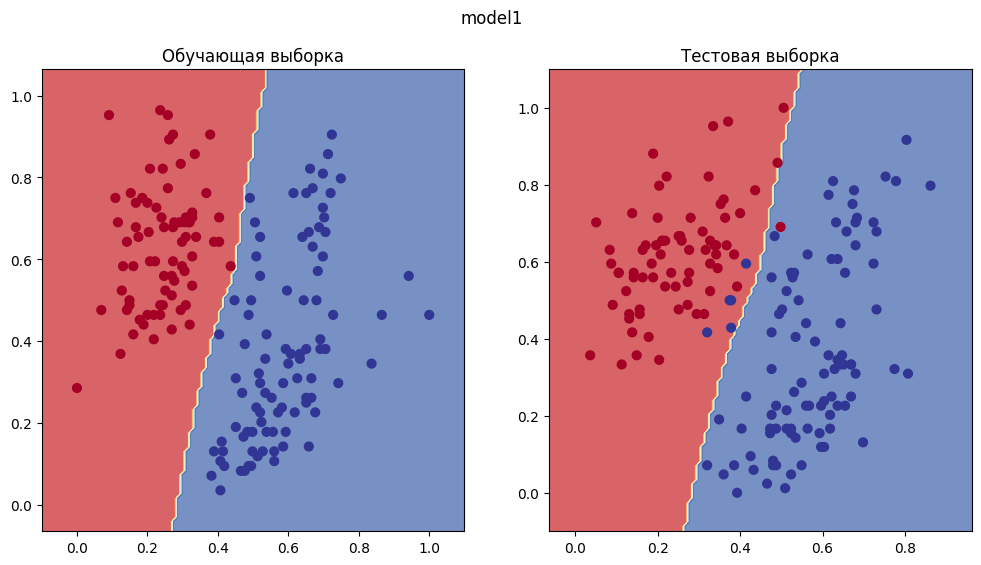

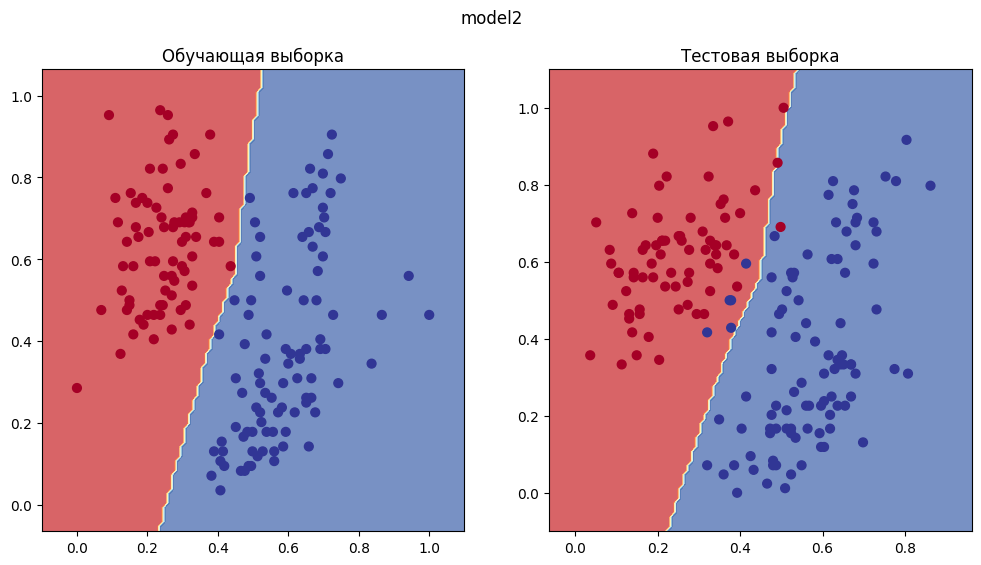

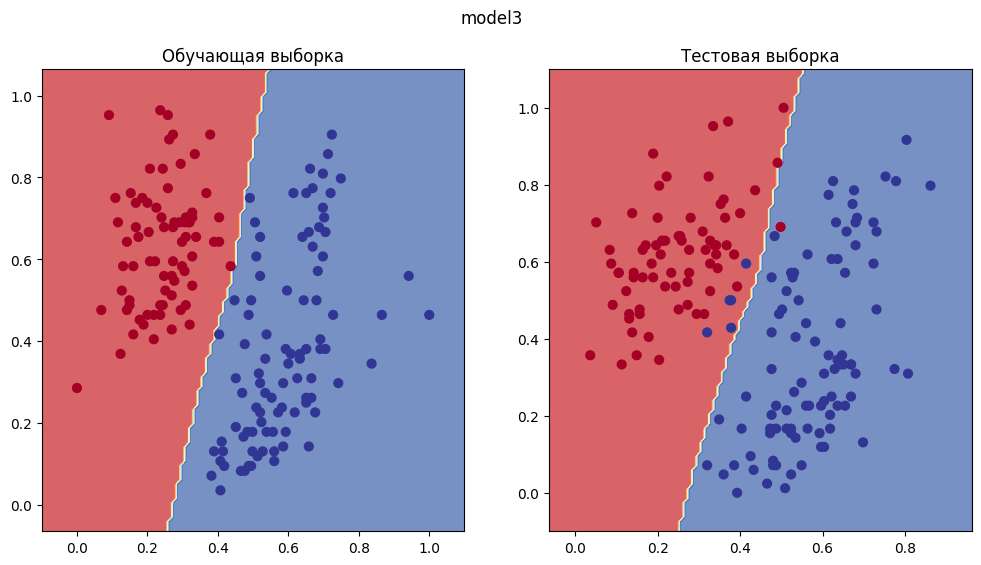

In [24]:
for model in models:
    plot_train_test_boundaries(model["model"])

## 6. ROC-анализ

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step


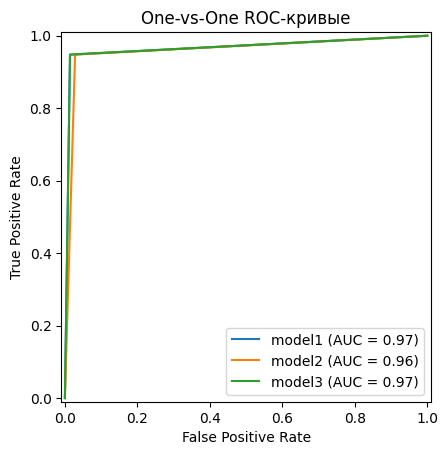

In [25]:
from sklearn.metrics import RocCurveDisplay

fix, ax = plt.subplots()

for model in models:
    pred = model["model"].predict(test_in)
    pred = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(pred)])
    RocCurveDisplay.from_predictions(
        test_out,
        pred,
        name=model["model"].name,
        ax=ax,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-One ROC-кривые",
)

## 7. Поиск дополнительного признака

In [26]:
df2 = full_df.drop(columns=[CLS, X0, X1])
df2.head()

,V2,V3
0,0.898305,0.638889
1,0.644068,0.402778
2,0.915254,0.694444
3,0.813559,0.680556
4,0.847458,0.708333


In [27]:
X2 = df2.var().idxmax()
X2

'V2'

In [28]:
df = pd.DataFrame(full_df, columns=[CLS, X0, X1, X2])
df.head()

,species,V0,V1,V2
0,2,0.654545,0.226190,0.898305
1,2,0.360000,0.047619,0.644068
2,2,0.680000,0.309524,0.915254
3,2,0.618182,0.202381,0.813559
4,2,0.552727,0.261905,0.847458


## 8. Визуализация с дополнительным признаком

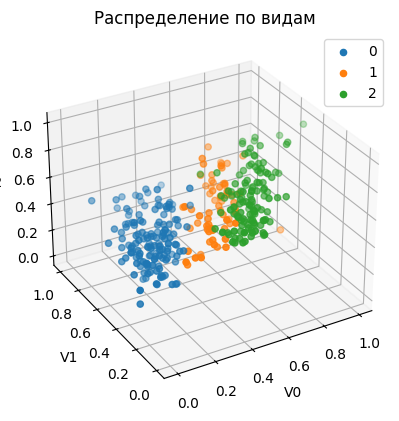

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.set_xlabel(X0)
ax.set_ylabel(X1)
ax.set_zlabel(X2)

for grp_name, grp_idx in df.groupby(CLS).groups.items():
    ax.scatter(
        df.iloc[grp_idx][X0],
        df.iloc[grp_idx][X1],
        df.iloc[grp_idx][X2],
        label=grp_name)

ax.view_init(elev=30, azim=-120)
plt.title("Распределение по видам")
ax.legend()

## 9. Многоклассовая классификация

In [30]:
model_config = None
for c in configs:
    if c["name"] == best_model:
        model_config = c
        break
model_config

{'name': 'model1', 'layers': 2, 'neurons_in_layer': 64}

In [31]:
seed = 123
split = 0.5
train = df.sample(frac=split, random_state=seed)
test = df.drop(train.index)
len(train), len(test)

(167, 167)

In [32]:
def to_one_hot(dataframe, dimension=3):
    results = np.zeros((len(dataframe), dimension))
    for i, label in enumerate(dataframe.to_numpy()):
        label = label[0]
        results[i, label] = 1.
    return results

In [33]:
train_in = np.asarray(train.drop(columns=[CLS]))
train_out = to_one_hot(pd.DataFrame(train, columns=[CLS]))

test_in = np.asarray(test.drop(columns=[CLS]))
test_out = to_one_hot(pd.DataFrame(train, columns=[CLS]))

full_in = np.asarray(df.drop(columns=[CLS]))
full_out = to_one_hot(pd.DataFrame(df, columns=[CLS]))

In [34]:
norm = tf.keras.layers.Normalization(axis=None)
norm.adapt(train_in)

In [35]:
layers = [tf.keras.layers.Dense(model_config["neurons_in_layer"], activation="selu") for _ in range(model_config["layers"])]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape= train_in[0].shape),
    norm,
    *layers,
    tf.keras.layers.Dense(3, activation="softmax")
])

model.summary()

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    metrics=["accuracy", "false_positives"]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 3)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,614 (18.03 KB)

 Trainable params: 4,611 (18.01 KB)

 Non-trainable params: 3 (16.00 B)

In [36]:
hist = model.fit(train_in, train_out, epochs=1000, verbose=0)

In [37]:
def plot_loss(title, history, squeze=0.3):
    plt.figure()
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(title)
    plt.ylim([min(history.history["loss"]) * (1 - squeze), max(history.history['loss']) * squeze])
    plt.xlabel("Эпохи обучения")
    plt.ylabel("Ошибка")
    plt.legend()
    plt.grid(True)

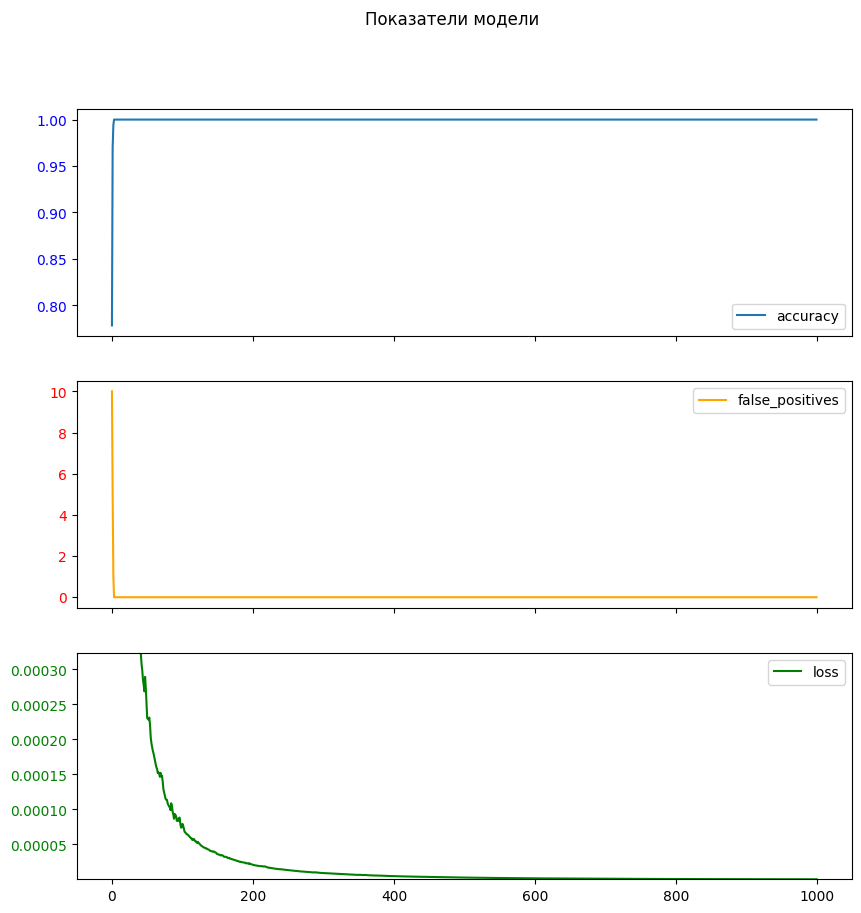

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(10, 10))

plt.suptitle("Показатели модели")
ax1.plot(hist.history['accuracy'], label='accuracy')
ax1.tick_params(axis='y', labelcolor='blue')

ax2.plot(hist.history['false_positives'], label='false_positives', color='orange')
ax2.tick_params(axis='y', labelcolor='red')

ax3.plot(hist.history['loss'], label='loss', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.set_ylim([min(hist.history["loss"]), max(hist.history["loss"]) * 0.001])

ax1.legend()
ax2.legend()
ax3.legend()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


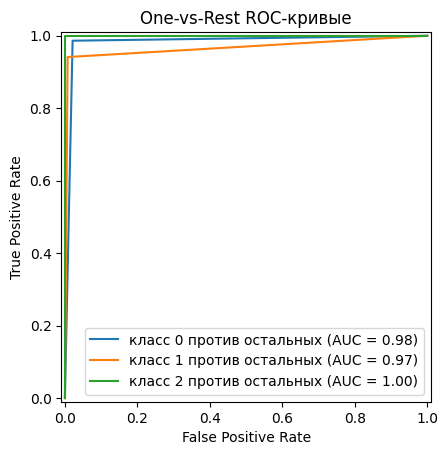

In [39]:
fig, ax = plt.subplots()

pred = model.predict(full_in)
pred = np.array([[1 if prob > 0.5 else 0 for prob in x] for x in pred])
for i in [0,1,2]:
    RocCurveDisplay.from_predictions(
        full_out[:, i],
        pred[:, i],
        name=f"класс {i} против остальных",
        ax=ax
    )
_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC-кривые",
)
